In [34]:
import torch
import torch.nn.functional as F 
import random
import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [35]:
# Data Read

words = open('../names.txt', 'r').read().splitlines()

chrs = sorted(list(set(''.join(words))))
# SET :: Duplicates Not Allowed
stoi = {s:i+1 for i, s in enumerate(chrs)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
stoi["s"] 

19

In [43]:
# PARAMETERS
g = torch.Generator().manual_seed(1337)
block_size = 8
batch_size = 32
embedding_depth = 8
embed_size = block_size * embedding_depth
hidden_layer = 100
output_layer = len(stoi)

max_steps = 30000

lre = torch.linspace(-2, -3, max_steps)
lrs = 10**lre

C = torch.randn((output_layer, embedding_depth), generator=g)
W1 = torch.randn((embed_size, hidden_layer), generator=g)
b1 = torch.randn(hidden_layer, generator=g)
m1 = torch.nn.BatchNorm1d(hidden_layer)
W2 = torch.randn((hidden_layer, output_layer), generator=g)
b2 = torch.randn(output_layer, generator=g)

parameters = [C, W1, b1, W2, b2] + list(m1.parameters())
for p in parameters:
    p.requires_grad = True

elm = sum(p.numel() for p in parameters)
elm


9643

In [44]:
# Data Set

def data_create(words, block_size):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

random.seed(66)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

X, Y = data_create(words, block_size)
Xtr, Ytr = X[:n1], Y[:n1]
Xdev, Ydev = X[n1:n2], Y[n1:n2]
Xtst, Ytst = X[n2:], Y[n2:]

In [ ]:
# # model parameters
# C = C.to(device)
# W1 = W1.to(device)
# b1 = b1.to(device)
# W2 = W2.to(device)
# b2 = b2.to(device)

# # training data
# Xtr = Xtr.to(device)
# Ytr = Ytr.to(device)
# Xdev = Xdev.to(device)
# Ydev = Ydev.to(device)

In [45]:
# MODEL

lri = []
lossi = []
lossi_val = []
for step in range(max_steps):
    
    # batch creation
    b_index = torch.randint(0, Xtr.size(0), (batch_size,))

    # forward
    emb = C[Xtr[b_index]].view(-1, embed_size)
    h = m1(emb @ W1 + b1)
    h = torch.tanh(h)
    logits = h @ W2 + b2
    # probs = torch.softmax(logits, dim=1)
    # loss = -probs[torch.arange(batch_size), Ytr[b_index]].log().mean()
    loss = F.cross_entropy(logits, Ytr[b_index])

    # eval
    with torch.no_grad():
        emb_v = C[Xdev].view(-1, embed_size)
        h_v = m1(emb_v @ W1 + b1)
        h_v = torch.tanh(h_v)
        logits_v = h_v @ W2 + b2
        # probs_v = torch.softmax(logits_v, dim=1)
        loss_v = F.cross_entropy(logits_v, Ydev)

    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = 0.005
    lr = lrs[step]
    for p in parameters:
        p.data += -lr * p.grad

    lri.append(lr)
    lossi.append(loss.item())
    lossi_val.append(loss_v.item())
loss

tensor(2.5064, grad_fn=<NllLossBackward0>)

In [39]:
# generator

for _ in range(20):

    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(-1, embed_size) @ W1 + b1)
        logits = h @ W2 + b2
        probs = torch.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
    # print(out)



ktttltqnysnuucrkdllbjwpiqrdrqikjeauuf.
xtpllvtqqksa.
xtpllvtvqcqtiqevqizheabvu.
xtpllptfsgsqiqgwoufxbhmvbuwvqozvxbakesayv.
xtpllvtvqosqkquhbwtrxakdbxqh.
tttttqtaqisdhajjhjptqgjahpufffwrqqhfw.
xtpllptfsgqqiqifoaxarbhhbiqjubufurvbhdhx.
xtpllvtvqcqtiqeznefubarqohbxbj.
xtpllptfsgqqiqiqbufufarrmhbhbjqahqffvxqgippxijhwpkhfxqcpkphwvjaqphulwxkhllxtoagihou.
vtttlhkiofxbzkrqbqaeoufarjmxbutrxuh.
xtpllvtvqtsu.
vtttlhkbsizgusufrvprgdjsbqbabufufabrbubkbabzbsquzafqrqagouxbu.
vtttlbpaqiqsoqzw.
vtttlbpaqiqsuluwahhdlytvqgisuzuudbxdjl.
vtttlbpaqiqsuqqkarqtsnhojfxxqgufwfwrrgrbiqbeateufh.
xtpkvvtmqkqezubqhxaemxhej.
vtttlbpaqiqsoqvwarcesekjtvzgoriaqihalduvvhtvqlsciqsk.
vtttlbpbsrquugkfw.
xtpllvtvqosqhuuvkhw.
ctttltonarqrhbllyjafxrjmubvfogihuuufvddllbkspquqdmqnhjrquwqbsezqizaxam.


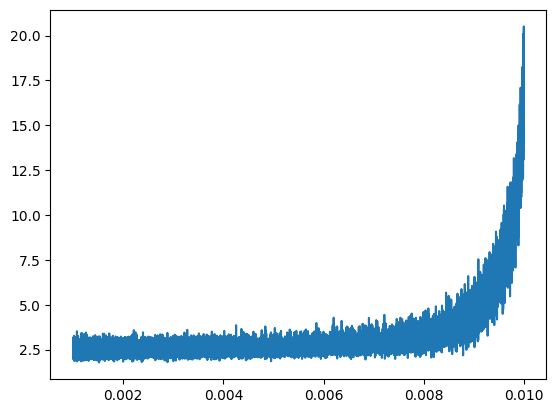

In [40]:
plt.plot(lri, lossi);

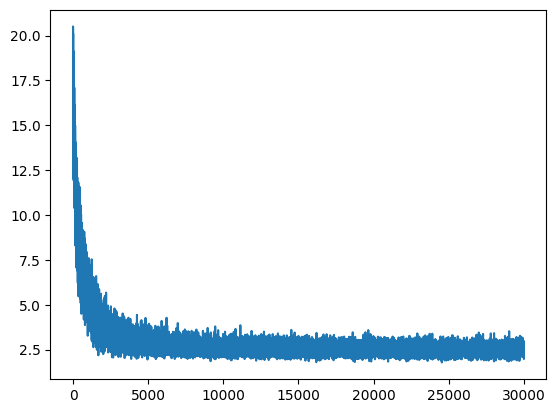

In [41]:
plt.plot(lossi);

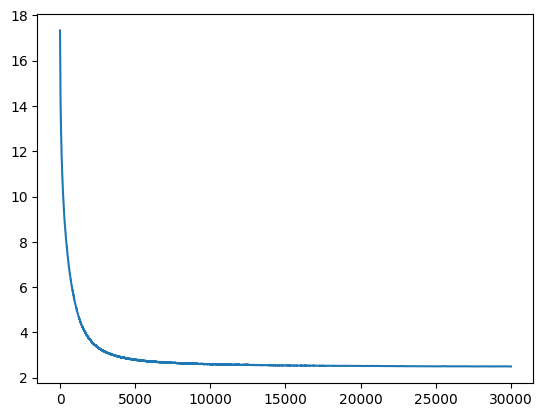

In [42]:
plt.plot(lossi_val);

In [14]:
C.size()

torch.Size([27, 8])

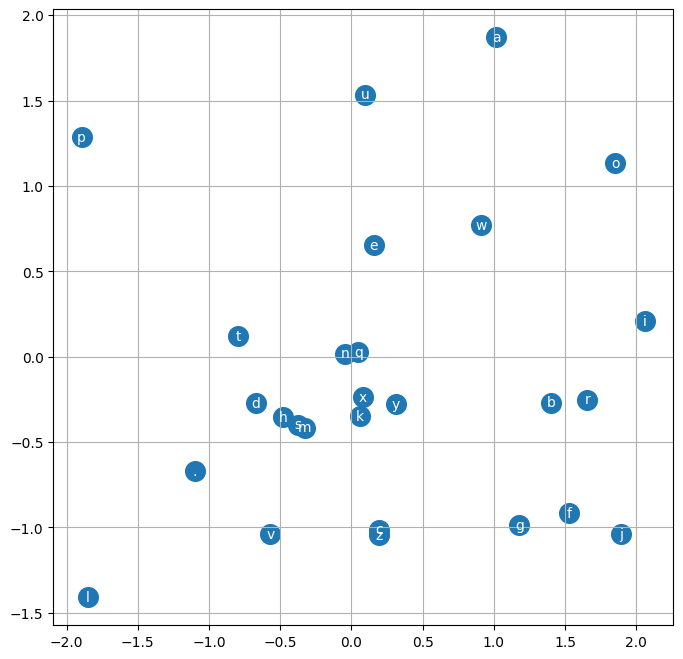

In [33]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')